## Intoduction.
We will be working mostly with the high level Keras API that comes bundled with tensorflow. The workflow is pretty straight forward:
- Load the data:
To get the most out of google colab, I recommend, uploading the dataset to your drive as a zipped file or tarball, then mounting your drive on colab and running the `unzip` command on the path to the dataset. This may seem like a lot of work, but will be worth it since when you unzip the file from colab, it saves the extracted files **temporarily** to your colab runtime and thus reduces IO overhead when running the directory iterators.
- Once the files are all setup, we then load the mobilenet_v2 and do some fine tuning for it to suit our needs.
- From there, all thats left is training the model, evaluating its metrics and iterating on said metrics until we get something desirable.

**Remember to set the runtime on colab to a GPU to get faster results**


## First, all the usual imports:

In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D


## Mounting google drive

The first time running the notebook will require you to allow access to your drive from colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the data
This is the aforementioned command to extract all the files.
Incase your file is in a different format, (tarball, rar.. etc.), you can search for the corresponding linux command to extract the data, but generally, for tarballs you can run:
```bash
!tar -xf some_tarball.gz
```
And for rar files you can run:
```bash
!unrar some_rarfile.rar
```

Do note that colab resets the runtime everytime you close it, so you will always have to rerun the command everytime. Reasons for this long winded approach have been explained in the introduction cell.

In [ ]:
!unzip /content/drive/MyDrive/Digitalfarmer/PlantVillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/5e9291cf-c9b5-4a3c-bf58-9bc155c4ce86___RS_HL 6796.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5ef306df-0c35-444a-a940-7f52b993ede1___RS_HL 6175.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5f1b1ee2-896c-43dd-8605-2bc4fde25277___RS_HL 3318.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5f818751-6536-4773-ab39-327199d79cfa___RS_HL 5655.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5fb2bc9c-b1e5-4798-9c7c-c8b08802631a___RS_HL 3697.JPG  
  inflating: PlantVillage/val/Soybean___healthy/603fd431-c503-4761-991f-b90670c6e96d___RS_HL 3282.JPG  
  inflating: PlantVillage/val/Soybean___healthy/608e2dc7-7591-48a8-958a-da698f8abfe6___RS_HL 3423.JPG  
  inflating: PlantVillage/val/Soybean___healthy/60a7d584-8124-4d3b-abae-4de8f0a8d892___RS_HL 4275.JPG  
  inflating: PlantVillage/val/Soybean___healthy/60a8e9b2-9a9b-47c7-b6d9-af8a850b02bf___RS_HL 6522.JPG  
  inflating: 

## Setting global constants and mounting the data path
One everything is extarcted, we then set the directories for the training and validation data sets and set some global constants to be used in the rest of the notebook.

In [ ]:
base_path = '/content/PlantVillage/'

train_data_dir = base_path + "/train"
val_data_dir = base_path + "/val"

os.chdir(base_path)
!dir 

mobilenet.h5  train  val


In [ ]:
img_size, batch_size, shuffle_size = 224, 32, 1000
img_shape = (img_size, img_size, 3)

## Creating the Image Data Generators
Finally, we get to the fun stuff. We create the desired generators and provide some data augmentation options to it, to get a larger dataset and then feed the generators to a directory iterator that will supply the model with the images.

The output of the following cell reveals to us how many classes were discovered.

In [ ]:
gen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size)
)

val_generator = gen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size)
)

Found 44135 images belonging to 39 classes.
Found 11065 images belonging to 39 classes.


## Saving the dataset labels
The generators has an attribute named `class_indices` that contains the data labels that have been supplied by keras.

We save this into a variable since we will require it later.

In [ ]:
labels = train_generator.class_indices

## Preparing MobileNetV2
Keras comes packed with some models and for our case we will be using MobileNetV2, for this notebook. The first running this cell will fetch the model from the internet but afterwards the model becomes cached. Since we want the model to come with its weights, we set the value to imagenet and discrad the last 1000 layer with softmax activation for use in imagenet by setting the parameter include_top to false

In [ ]:
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)

mobile_net.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

## Fine Tuning MobileNet
In the following cell, we start fine tuning the model, through some experimentation of my own, I found the architecture below to result in pretty satisfying results with the training accuracy clocking at 0.98 and the validation accuracy not too far behind.

In [ ]:
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(39, activation='softmax')(x)


model = Model(mobile_net.input, x)

for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
checkpoint = ModelCheckpoint("pdd_model.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [ ]:
step_size = train_generator.n//train_generator.batch_size

model_history = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=step_size,
    validation_data=val_generator,
    validation_steps=25,
    callbacks = [checkpoint, early]
)

Streaming output truncated to the last 5000 lines.
1379/1379 [==============================] - 672s 487ms/step - loss: 0.1102 - acc: 0.9639 - val_loss: 0.1833 - val_acc: 0.9525
Epoch 3/5
1379/1379 [==============================] - 687s 498ms/step - loss: 0.0817 - acc: 0.9729 - val_loss: 0.1975 - val_acc: 0.9500
Epoch 4/5
1379/1379 [==============================] - 698s 506ms/step - loss: 0.0662 - acc: 0.9777 - val_loss: 0.1252 - val_acc: 0.9675
Epoch 5/5
1379/1379 [==============================] - 706s 512ms/step - loss: 0.0523 - acc: 0.9821 - val_loss: 0.0719 - val_acc: 0.9750


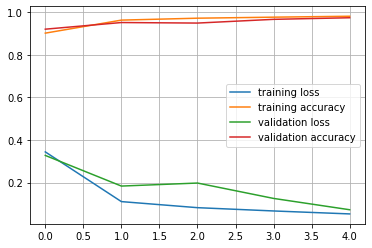

In [ ]:
plt.plot(model_history.history['loss'], label = 'training loss')
plt.plot(model_history.history['acc'], label = 'training accuracy')
plt.grid(True)
plt.legend()

plt.plot(model_history.history['val_loss'], label = 'validation loss')
plt.plot(model_history.history['val_acc'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [ ]:
model.save('pdd_mobilenet2_v1.h5')

In [ ]:
def preprocess_image(file):
  path = '/content/drive/MyDrive/Digitalfarmer/random_tests/'
  img = image.load_img(path + file, target_size=(224,224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet_v2.preprocess_input(img_array_expanded_dims)


In [ ]:
def get_prediction(image, level='all'):
  preprocessed_image = preprocess_image(image)
  predictions = model.predict(preprocessed_image)

  ind = np.argpartition(predictions[0], -5)[-5:]
  result = np.argmax(predictions[0])
  top5= predictions[0][ind]

  if level == 'single':
     for k,v in labels.items():
       if v == result: return k;
  else:
    for k,v in labels.items():
      if v in np.sort(ind):
        idx = np.where(ind == v)[0]
        print(f'{top5[idx]} ~> {k}')



 

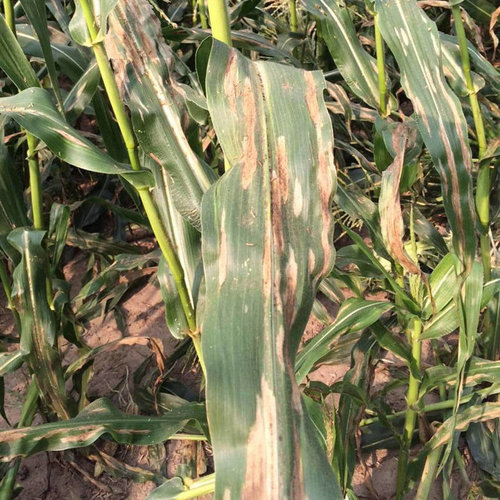

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Digitalfarmer/random_tests/corn_scorch.jpg', width=300, height=200)

In [ ]:
ans = get_prediction('corn_scorch.jpg')
ans

[0.1449509] ~> Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
[0.41161817] ~> Corn_(maize)___Northern_Leaf_Blight
[0.10924993] ~> Strawberry___Leaf_scorch
[0.29565668] ~> Tomato___Early_blight
[0.0247179] ~> Tomato___Target_Spot
